In [38]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import scipy as sp

In [39]:
(train_img,train_lable),(test_img,test_lable)=tf.keras.datasets.fashion_mnist.load_data()

In [40]:
print(train_img.shape)
print(train_lable.shape)
print(test_img.shape)
print(test_lable.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [41]:
train_img=train_img/255.
test_img=test_img/255.
train_img = train_img.reshape(60000, 28, 28, 1)
test_img = test_img.reshape(10000, 28, 28, 1)

In [42]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

ValueError: Cannot set memory growth on device when virtual devices configured

# Sequantial Model

In [43]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(16, input_shape=(28,28,1), kernel_size=(3,3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(10,activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 3, 128)        

# training

In [50]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['acc'])
history = model.fit(train_img,train_lable,epochs=5,validation_split=0.1, shuffle=True, batch_size=32)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 6s 110us/sample - loss: 0.2275 - acc: 0.9160 - val_loss: 0.2527 - val_acc: 0.9058
Epoch 2/5
54000/54000 [==============================] - 6s 102us/sample - loss: 0.2089 - acc: 0.9222 - val_loss: 0.2388 - val_acc: 0.9127
Epoch 3/5
54000/54000 [==============================] - 5s 100us/sample - loss: 0.1929 - acc: 0.9288 - val_loss: 0.2294 - val_acc: 0.9172
Epoch 4/5
54000/54000 [==============================] - 5s 100us/sample - loss: 0.1800 - acc: 0.9329 - val_loss: 0.2388 - val_acc: 0.9135
Epoch 5/5
54000/54000 [==============================] - 6s 102us/sample - loss: 0.1666 - acc: 0.9379 - val_loss: 0.2222 - val_acc: 0.9185


# subclass

In [51]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

cam_model = tf.keras.models.Model(inputs=model.input, outputs=(model.layers[-3].output, model.layers[-1].output))
cam_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8_input (InputLayer)  [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 64)          0   

# show class activation map

In [57]:
def show_cam(i):
    image_index = i
    features_for_img = features[image_index, :, :, :]
    prediction = np.argmax(results[image_index])
    
    class_activation_weights = gap_weights[:, prediction]
    class_activation_features = sp.ndimage.zoom(features_for_img, (28/3, 28/3, 1), order=2)
    cam_output = np.dot(class_activation_features, class_activation_weights)
    print('Predicted Class = ' + str(prediction) + ', Probability = ' + str(results[image_index][prediction]))
    plt.imshow(np.squeeze(train_img[image_index], -1), alpha=0.5)
    
    if(results[image_index][prediction]>0.95):
        cmap_str = 'Greens'
    else:
        cmap_str = 'Reds'
    plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)
    plt.show()
    

Predicted Class = 8, Probability = 0.9121903


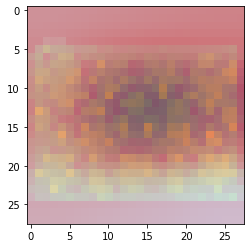

Predicted Class = 8, Probability = 0.9999999


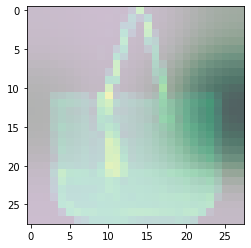

Predicted Class = 8, Probability = 0.99999523


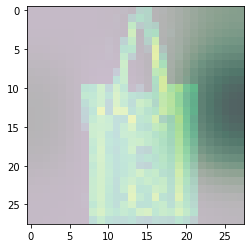

Predicted Class = 8, Probability = 0.9999945


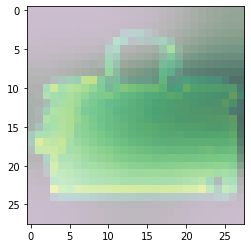

In [61]:
features, results = cam_model.predict(train_img)

desired_class = 8
for i in range(0, 100):
    if np.argmax(results[i]) == desired_class:
        show_cam(i)

In [54]:
features.shape

(60000, 3, 3, 128)

In [56]:
results.shape

(60000, 10)